# Spectral Model

This tutorial demonstrates how spectral normative modeling can be performed using the SpectraNorm package.

We will use the same hypothetical 2D lattice graph data and the eigenmode basis computed in the previous [tutorial on constructing graph spectral eigenbases]((/spectranorm/tutorials/eigenmode_bases/#a-simple-lattice-example)). Here, we will first describe how a hypothetical target variable (e.g., a hypothetical phenotype confined to the 2D lattice graph) could possibly be generated through a normative process, such that the value of the target variable at any given node on the lattice follows a normative distribution that depends on the value of a continous covariate (e.g., age).

This hypothetical case, will in a way combine the concepts of normative modeling (described for a univariate case in an earlier tutorial) with spectral representations of data defined on graphs (described in the previous tutorial). We will then fit a spectral normative model to this hypothetical data, then visualize and evaluate the results.

### Package Imports

The following notebook cell imports the necessary packages and modules for this tutorial:


In [1]:
# Several imports used in this notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse, stats

# Import the SpectraNorm package
from spectranorm import snm



### 2D Lattice Graph

Similar to the previous tutorial, we will generate a 2D lattice graph with 50x50 nodes to represent our hypothetical high-dimensional feature space.


In [2]:
# Define the number of nodes along each dimension
num_nodes = 50

# Create a grid of points
x = np.linspace(0, 1, num_nodes)
y = np.linspace(0, 1, num_nodes)
X, Y = np.meshgrid(x, y)

# Flatten the grid to create a list of node coordinates
nodes = np.column_stack((X.flatten(), Y.flatten()))

# Let's create a sparse adjacency matrix to represent the connections between the nodes
adjacency_matrix = sparse.lil_matrix((num_nodes**2, num_nodes**2))

# Connect each node to its immediate neighbors (up, down, left, right)
for i in range(num_nodes):
    for j in range(num_nodes):
        node_index = i * num_nodes + j
        if i > 0:  # Connect to the node above
            adjacency_matrix[node_index, (i - 1) * num_nodes + j] = 1
        if i < num_nodes - 1:  # Connect to the node below
            adjacency_matrix[node_index, (i + 1) * num_nodes + j] = 1
        if j > 0:  # Connect to the node to the left
            adjacency_matrix[node_index, i * num_nodes + (j - 1)] = 1
        if j < num_nodes - 1:  # Connect to the node to the right
            adjacency_matrix[node_index, i * num_nodes + (j + 1)] = 1

# Let's convert the adjacency matrix to a more efficient format for computations
adjacency_matrix = adjacency_matrix.tocsr()


### Loading the Eigenmode Basis

We will load the eigenmode basis that was computed and saved in the previous tutorial:

In [3]:
eigenmode_basis = snm.utils.gsp.EigenmodeBasis.load("eigenmode_basis.joblib")

## Hypothetical Target Variable

Given that we have a 2D lattice graph and its corresponding eigenmode basis, we can now generate a hypothetical target variable that follows a normative process defined over this 2D lattice. The 2D lattice can be used to describe a hypothetical image. For simplicity, we assume that this image (a 50x50 pixel image) describes a bivariate gaussian distribution of pixel intensities.

For this let's define a function that can generate such images from a minimal set of parameters (e.g., center coordinates of the bivariate gaussian, it's angle of orientation, and its standard deviation along the major and minor axes). Next, we will use this function to generate a set of hypothetical images (training data) that describes the normative dependency of the target variable (image) on a continuous covariate (e.g., age).

In [22]:
def generate_bivariate_gaussian_image(center_x, center_y, angle, sigma_major, sigma_minor):
    num_nodes = 50
    x = np.linspace(0, 1, num_nodes)
    y = np.linspace(0, 1, num_nodes)
    X, Y = np.meshgrid(x, y)

    # Create the covariance matrix for the bivariate Gaussian
    theta = np.radians(angle)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    D = np.diag([sigma_major**2, sigma_minor**2])
    covariance_matrix = R @ D @ R.T
    mean = np.array([center_x, center_y])

    # Compute the bivariate Gaussian distribution
    pos = np.dstack((X, Y))
    inv_cov = np.linalg.inv(covariance_matrix)
    norm_const = 1.0 / (np.power(2 * np.pi, 2) * np.sqrt(np.linalg.det(covariance_matrix)))
    diff = pos - mean
    exponent = -0.5 * np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    return norm_const * np.exp(exponent)

# a function to generate hypothetical images based on a set of
# covariate values (e.g., age)
def generate_hypothetical_images(age, noise_level=1e-6):
    # Define the parameters of the bivariate Gaussian based on the covariates
    center_x = 0.5 + 0.1 * np.cos(age / 10) + np.random.normal(0, noise_level)
    center_y = 0.5 + 0.1 * np.sin(age / 10) + np.random.normal(0, noise_level)
    angle = age / 30 * 180 / np.pi  # Convert to degrees
    sigma_major = 0.25 + 0.02 * np.sin(age / 20) + np.random.normal(0, noise_level)
    sigma_minor = 0.15 - 0.02 * np.sin(age / 20) + np.random.normal(0, noise_level)

    # Generate the bivariate Gaussian image
    return generate_bivariate_gaussian_image(
        center_x, center_y, angle, sigma_major, sigma_minor) + 0.6 * ((age-40)/20)**2



Let's see what this hypothetical function relating age to the target variable (image) looks like. Below, we will generate a set of hypothetical images for a range of ages, and visualize how the images change as a function of age. This will give us an intuition about the hypothetical normative process that we are trying to model with our spectral normative model.

/tmp/ipykernel_1334986/407263316.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


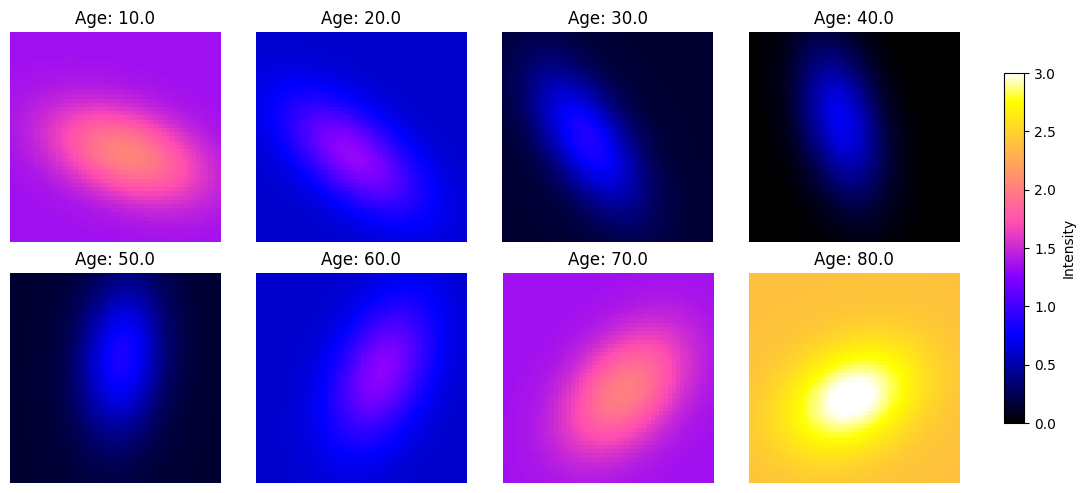

In [28]:
candidate_ages = np.linspace(10, 80, 8)

hypothetical_images = np.array([
    generate_hypothetical_images(age) for age in candidate_ages])

# Visualize the hypothetical images
fig, axes = plt.subplots(2, len(candidate_ages)//2, figsize=(10, 5))
for i, age in enumerate(candidate_ages):
    row = i // (len(candidate_ages)//2)
    col = i % (len(candidate_ages)//2)
    axes[row, col].imshow(
        hypothetical_images[i].reshape(50, 50),
        cmap="gnuplot2", vmin=0, vmax=3)
    axes[row, col].set_title(f"Age: {age:.1f}")
    axes[row, col].axis("off")

# Show the colorbar in a new axis on the right
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap="gnuplot2", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Intensity")
plt.tight_layout()
plt.show()

As expected, the magnitude, position, angle, and roundedness of the image changes as a function of age, following the hypothetical normative process that we defined.

## Generating Training Data

Now that we have defined the hypothetical normative process that relates a covariate (age) to the target variable (image intensities) characteristics, we can generate a set of training data by sampling from this process at different ages. We will assume that the normative mean is described by the hypothetical function we defined above, and that the variance is proportional to the mean while linearly increasing with age. Finally, we will also add a random batch effect (e.g., akin to a scanner effect) that introduces a uniform shift in the observed image intensities across all pixels.

Notably, the function to generate the hypothetical images includes a noise term that adds some variability to the generated images, which is similar to the variability we would expect to see in real-world data (e.g., due to individual differences, measurement noise, etc.).

In a sense, this setup is equivalent to a normative modeling setup where we have a separate univariate model for each pixel (the value of a single pixel follows a predefined distribution that depends on the covariate values). However, given that we have formulated the normative process to be defined in the image space, we expect a multivariate spectral normative model to be able to capture this process indirectly.

All that said, let's generate the training data and generate visualizations to better understand the data that we are working with.

In [29]:
# Fix the random seed for reproducibility
np.random.seed(42)

sample_size = 3000
data = pd.DataFrame({
    "age": np.random.uniform(10, 80, size=sample_size),
    "site": np.random.choice(["A", "B", "C", "D", "E", "F"], size=sample_size),
})
site_effects_prior = np.random.normal(0, 1, size=data["site"].nunique())
site_effects = data["site"].map(dict(zip(data["site"].unique(), site_effects_prior)))

age_dependent_images = np.array([
    generate_hypothetical_images(age, noise_level=1e-3).flatten()
    for i, age in enumerate(data["age"])
])
phenotype_mean = age_dependent_images + 0.5 * np.array(site_effects)[:, np.newaxis]
phenotype_std = 0.1 * phenotype_mean + np.array([
    0.01 * age for age in data["age"]
])[:, np.newaxis]

observed_phenotypes = (
    phenotype_mean +
    np.random.normal(0, 1, size=sample_size)[:, np.newaxis] * phenotype_std)

phenotype_mean.shape, phenotype_std.shape, observed_phenotypes.shape


((3000, 2500), (3000, 2500), (3000, 2500))

Let's first look at the distribution of data at a single pixel across all ages:

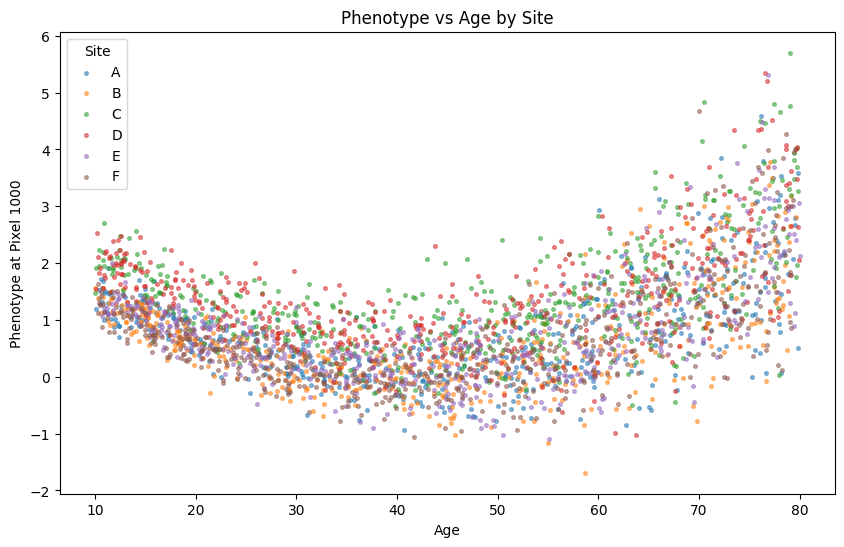

In [30]:
plt.figure(figsize=(10, 6))
for site in sorted(data["site"].unique()):
    subset = data[data["site"] == site]
    pixel_index = 1000  # Example pixel index to visualize
    plt.scatter(
        subset["age"], observed_phenotypes[subset.index, pixel_index],
        alpha=0.5, label=f"{site}", s=7)
plt.xlabel("Age")
plt.ylabel(f"Phenotype at Pixel {pixel_index}")
plt.title("Phenotype vs Age by Site")
plt.legend(title="Site")
plt.show()


Let's also look at the data from a few different samples across the age range to see how the images change with age and site (batch effect):

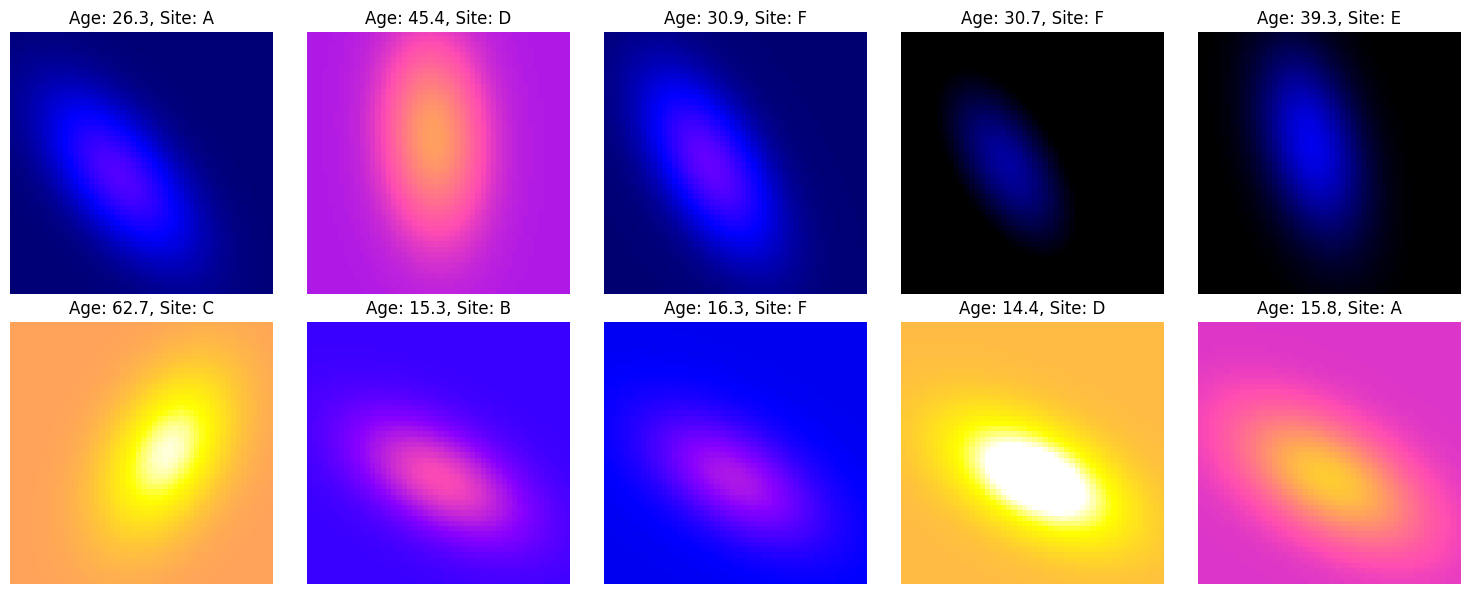

In [33]:
number_of_samples = 10
sample_indices = np.random.choice(
    observed_phenotypes.shape[0], size=number_of_samples, replace=False)
fig, axes = plt.subplots(2, number_of_samples//2, figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    row = i // (number_of_samples//2)
    col = i % (number_of_samples//2)
    axes[row, col].imshow(
        observed_phenotypes[idx].reshape(50, 50), cmap="gnuplot2", vmin=0, vmax=3)
    axes[row, col].set_title(
        f"Age: {data.loc[idx, 'age']:.1f}, Site: {data.loc[idx, 'site']}")
    axes[row, col].axis("off")
plt.tight_layout()
plt.show()


Now that we have a better understanding of the data, we can proceed to fit a spectral normative model to this data, and evaluate how well the model captures the underlying normative process that we defined.

### Generating Test Data

Noting the we will also likely need some test data to evaluate the model, we can generate a separate test set using the same process as above, but with different random seeds to ensure that the test data is different from the training data.

In [67]:
# Fix the random seed for reproducibility
np.random.seed(43)

test_sample_size = 1000
test_data = pd.DataFrame({
    "age": np.random.uniform(10, 80, size=test_sample_size),
    "site": np.random.choice(["A", "B", "C", "D", "E", "F"], size=test_sample_size),
})
site_effects = test_data["site"].map(
    dict(zip(data["site"].unique(), site_effects_prior)))

test_age_dependent_images = np.array([
    generate_hypothetical_images(age, noise_level=1e-3).flatten()
    for i, age in enumerate(test_data["age"])
])
test_phenotype_mean = (
    test_age_dependent_images + 0.5 * np.array(site_effects)[:, np.newaxis])
test_phenotype_std = 0.1 * test_phenotype_mean + np.array([
    0.01 * age for age in test_data["age"]
])[:, np.newaxis]

observed_test_phenotypes = (
    test_phenotype_mean +
    np.random.normal(0, 1, size=test_sample_size)[:, np.newaxis] * test_phenotype_std)

test_phenotype_mean.shape, test_phenotype_std.shape, observed_test_phenotypes.shape

((1000, 2500), (1000, 2500), (1000, 2500))

## Defining the Spectral Model

To define the spectral normative model, we will need to specify two main components: the spectral basis functions (which we have already computed and loaded, i.e., the eigenmode basis), and the normative model specification (i.e., how the normative mean and variance depend on the covariates). For the normative model specification, we can use a base univariate normative model (defined by [`snm.DirectNormativeModel`](/spectranorm/api/snm/#spectranorm.snm.DirectNormativeModel)). Here, we will specify a similar model to what was defined in the previous [univariate normative modeling tutorial](/spectranorm/tutorials/univariate_model/#defining-the-model).

The Spectral Normative Model will be defined using the [`snm.SpectralNormativeModel`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel) class, which can be initialized with the eigenmode basis and the base univariate normative model instances. Here, we will use the [`SpectralNormativeModel.build_from_dataframe`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.build_from_dataframe) method, which automates the process of specifying the base model, directly from a dataframe containing the covariates (much similar to the univariate normative modeling tutorial).

In [35]:
# Now we can define the spectral normative model
spectral_normative_model = snm.SpectralNormativeModel.build_from_dataframe(
    eigenmode_basis=eigenmode_basis,
    # Hierarchical Bayesian Regression (use a hierarchical prior on batch effects)
    model_type="HBR",
    # Pass the dataframe containing all covariates
    covariates_dataframe=data,
    # Specify the numerical covariates to include in the model
    numerical_covariates=["age"],
    # Specify which numerical covariates are modeled as nonlinear effects (B-splines)
    nonlinear_covariates=["age"],
    # Specify the categorical covariates included in the model (including batch effects)
    categorical_covariates=["site"],
    # Specify whether any categorical covariates should be treated as batch effects
    batch_covariates=["site"],
    # Specify which covariates influence the mean of the target variable
    influencing_mean=["age", "site"],
    # Specify which covariates influence the variance of the target variable
    influencing_variance=["age", "site"],
)

spectral_normative_model

SpectralNormativeModel(eigenmode_basis=EigenmodeBasis(n_modes=100, n_features=2500), base_model=DirectNormativeModel(spec=NormativeModelSpec(variable_of_interest='dummy_VOI', covariates=[CovariateSpec(name=site, cov_type=categorical, hierarchical=True, n_categories=6), CovariateSpec(name=age, cov_type=numerical, effect=spline)], influencing_mean=['age', 'site'], influencing_variance=['age', 'site'])))

The example above is one of the simplest possible specifications of a spectral normative model. In later tutorials, we will explore more detailed specification approaches by which you can control parameters such as the basis expansion of the covariates, the prior distributions of the model parameters, and the model inference approach. For now, let's keep it simple and see how this specified spectral model performs on the data.

## Training the spectral model

In order to train the spectral normative model, we first need to compute the spectral coefficients summarizing the high-dimensional image data (across all pixels) into the spectral space defined by the eigenmode basis.

### Computing Spectral Coefficients

The script below computes the spectral coefficients for the training data by projecting the high-dimensional image data onto the eigenmode basis:

In [68]:
spectral_coefficients_train = np.array([
    observed_phenotypes[i] @ eigenmode_basis.eigenvectors
    for i in range(observed_phenotypes.shape[0])
])

# Let's similarly project the test phenotypes into the spectral space
spectral_coefficients_test = np.array([
    observed_test_phenotypes[i] @ eigenmode_basis.eigenvectors
    for i in range(observed_test_phenotypes.shape[0])
])

spectral_coefficients_train.shape

(3000, 100)

### Fitting the model

The script below fits the spectral normative model to the training data by calling the [`SpectralNormativeModel.fit`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.fit) method, which estimates the parameters of the model based on the provided data and covariates.

> Note: the fitting process can be parallelized across multiple CPU cores by setting the `n_jobs` parameter of the `fit` method to a value greater than 1 (e.g., `n_jobs=-1` to use all available cores, which is the default setting).

In [53]:
spectral_normative_model.fit(
    spectral_coeff_train_data=spectral_coefficients_train,
    covariates_dataframe=data,
)


2026-02-17 21:19:29 : [INFO] - spectranorm.snm - Starting SNM model fitting:
2026-02-17 21:19:29 : [INFO] - spectranorm.snm - Step 1; direct models for each eigenmode (100 modes)


Fitting direct models:   0%|          | 0/100 [00:00<?, ?tasks/s]

2026-02-17 21:19:53 : [INFO] - spectranorm.snm - Step 2; identify sparse covariance structure
2026-02-17 21:19:54 : [INFO] - spectranorm.snm - Step 3; cross-eigenmode dependency modeling (49 pairs)


Fitting covariance models:   0%|          | 0/49 [00:00<?, ?tasks/s]

#### Model fit in spectral space

Now that the spectral normative model has been fitted, we have a multivariate normative model explaining how the spectral coefficients (which are the projections of the original high-dimensional data onto the eigenmode basis) depend on the covariates.

E.g. the following visualization shows the normative ranges for the first eigenmode coefficient as a function of age:

> Note: these ranges were extracted by definging a spatial query in the spectral space, such that it only considers the first eigenmode coefficient (i.e., the first element is one, and the rest are zeros). By using other spatial queries, we can extract normative ranges for any hypothetical linear combination of the high-dimensional data (as long as it can be captured by the eigenmode basis).

In [54]:
# let's define 10 queries for the first 10 modes
n_queries = 100
encoded_queries = np.zeros((spectral_normative_model.model_params["n_modes"], n_queries))
np.fill_diagonal(encoded_queries, 1)

# generate predicted charts
ages = np.linspace(10, 80, 200)

# create dummy dataframe for prediction
dummy_df = pd.DataFrame({
    "age": ages,
})

# predict moments
predicted_spectral_moments = spectral_normative_model.predict(
    encoded_query=encoded_queries[:n_queries],
    test_covariates=dummy_df, predict_without=['site'],
    n_modes=n_queries, # to simplify the inference
).predictions



Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

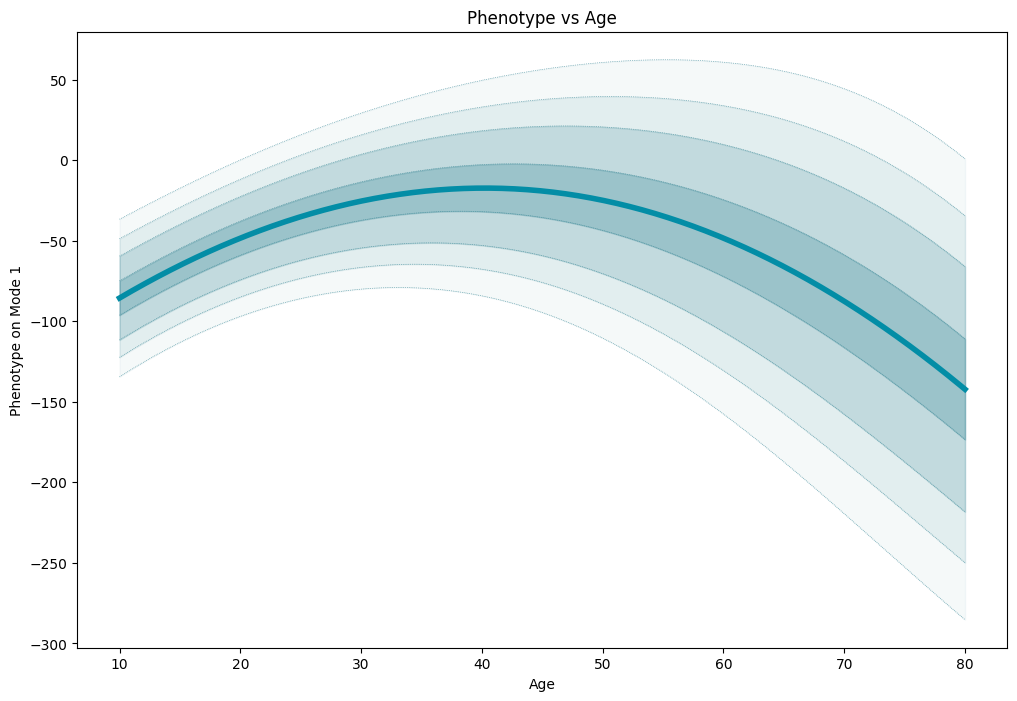

In [55]:
# Let's visualize the first mode's normative ranges as a function of age
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Predict moments (mean and std) of the normative distribution
moments = predicted_spectral_moments

# Let's compute charts along different quantiles
quantiles = [0.001, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

# Predict the phenotype values corresponding to different quantiles
phenotype_quantiles = {
    q: (moments["mu_estimate"][:,0] + stats.norm.ppf(q=q) * moments["std_estimate"][:,0])
    for q in quantiles
}

# Some colors for the plot
c1 = "#448e9c"  # brighter shade
c2 = "#038da6"  # darker shade

# Plotting shaded ranges for different quantiles
for q1, q2, alpha in [
    (0.001, 0.999, 0.05),
    (0.01, 0.99, 0.1),
    (0.05, 0.95, 0.2),
    (0.25, 0.75, 0.3)]:
    ax.fill_between(
        ages,
        phenotype_quantiles[q1],
        phenotype_quantiles[q2],
        alpha=alpha,
        color=c1,
    )

    # Now add boundary lines with different colors
    ax.plot(ages, phenotype_quantiles[q1], color=c1, lw=0.5, linestyle=":")
    ax.plot(ages, phenotype_quantiles[q2], color=c1, lw=0.5, linestyle=":")

# Finally, add the median line with a different color and higher line width
ax.plot(
    ages,
    phenotype_quantiles[0.5],
    c=c2,
    lw=4,
)
plt.xlabel("Age")
plt.ylabel("Phenotype on Mode 1")
plt.title("Phenotype vs Age");



We can also plot the scatters of the observed data encoded by this mode to verify if this is consistent with the data distribution in the spectral space.

> Note: as seen in the visualization below, the observed data approximately follows the estimated normative ranges, which is expected given that the data was generated from a process that follows the normative model specification we defined above. However, given that the visualization bellow is showing scatter points of the observed data (without harmonization), this visualization can become misleading, especially if there are strong batch effects in the data. In the next section, we will see how to harmonize the data in the spectral space to get a more accurate visualization of the observed data distribution (post-harmonization) in the spectral space.

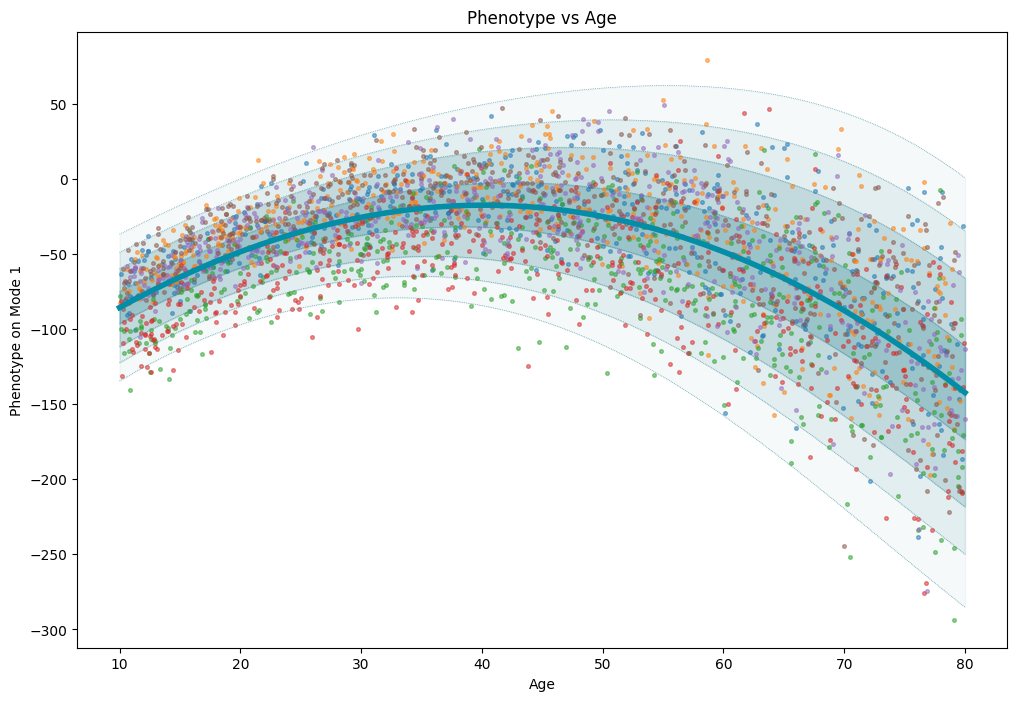

In [56]:
# Let's visualize the first mode's normative ranges as a function of age
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Predict moments (mean and std) of the normative distribution
moments = predicted_spectral_moments

# Let's compute charts along different quantiles
quantiles = [0.001, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

# Predict the phenotype values corresponding to different quantiles
phenotype_quantiles = {
    q: (moments["mu_estimate"][:,0] + stats.norm.ppf(q=q) * moments["std_estimate"][:,0])
    for q in quantiles
}

# Some colors for the plot
c1 = "#448e9c"  # brighter shade
c2 = "#038da6"  # darker shade

# Plotting shaded ranges for different quantiles
for q1, q2, alpha in [
    (0.001, 0.999, 0.05),
    (0.01, 0.99, 0.1),
    (0.05, 0.95, 0.2),
    (0.25, 0.75, 0.3)]:
    ax.fill_between(
        ages,
        phenotype_quantiles[q1],
        phenotype_quantiles[q2],
        alpha=alpha,
        color=c1,
    )

    # Now add boundary lines with different colors
    ax.plot(ages, phenotype_quantiles[q1], color=c1, lw=0.5, linestyle=":")
    ax.plot(ages, phenotype_quantiles[q2], color=c1, lw=0.5, linestyle=":")

# Finally, add the median line with a different color and higher line width
ax.plot(
    ages,
    phenotype_quantiles[0.5],
    c=c2,
    lw=4,
)

# In addition to the part above, the following add the encoded phenotype values
# as scatter points along the estimated normative range:
for site in sorted(data["site"].unique()):
    subset = data[data["site"] == site]
    plt.scatter(
        subset["age"], spectral_coefficients_train[subset.index][:,0],
        alpha=0.5, label=f"{site}", s=7)

plt.xlabel("Age")
plt.ylabel("Phenotype on Mode 1")
plt.title("Phenotype vs Age");



### Harmonizing the data in the spectral space

As explained in the note earlier, it is important to first harmonize the data to remove the batch effect (e.g., site effect) from the observed data. The [`SpectralNormativeModel.harmonize`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.harmonize) implements such a functionality. Notably, the harmonize function expects a list of spatial queries to harmonize the observed data as described by those spatial queries. Since we are currently using the eigenmode basis as the spatial query (i.e. the first query is the loading on the first mode), the results of this harmonization procedure gives us harmonized counterparts to the spectral coeefficients.

In [57]:
harmonized_spectral_coefficients_train = spectral_normative_model.harmonize(
    encoded_query=encoded_queries[:n_queries],
    covariates_dataframe=data,
    spectral_coeff_data=spectral_coefficients_train[:,:n_queries],
    covariates_to_harmonize=["site"],
    n_modes=n_queries, # to simplify the inference
)

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

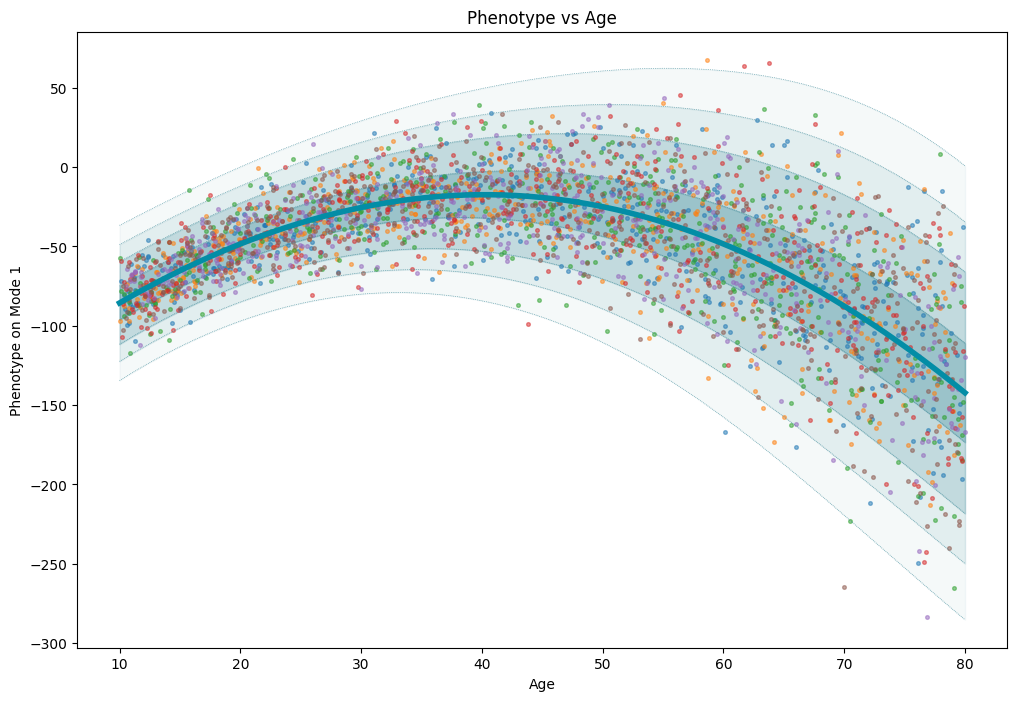

In [58]:
# Let's visualize the first mode's normative ranges as a function of age
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Predict moments (mean and std) of the normative distribution
moments = predicted_spectral_moments

# Let's compute charts along different quantiles
quantiles = [0.001, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

# Predict the phenotype values corresponding to different quantiles
phenotype_quantiles = {
    q: (moments["mu_estimate"][:,0] + stats.norm.ppf(q=q) * moments["std_estimate"][:,0])
    for q in quantiles
}

# Some colors for the plot
c1 = "#448e9c"  # brighter shade
c2 = "#038da6"  # darker shade

# Plotting shaded ranges for different quantiles
for q1, q2, alpha in [
    (0.001, 0.999, 0.05),
    (0.01, 0.99, 0.1),
    (0.05, 0.95, 0.2),
    (0.25, 0.75, 0.3)]:
    ax.fill_between(
        ages,
        phenotype_quantiles[q1],
        phenotype_quantiles[q2],
        alpha=alpha,
        color=c1,
    )

    # Now add boundary lines with different colors
    ax.plot(ages, phenotype_quantiles[q1], color=c1, lw=0.5, linestyle=":")
    ax.plot(ages, phenotype_quantiles[q2], color=c1, lw=0.5, linestyle=":")

# Finally, add the median line with a different color and higher line width
ax.plot(
    ages,
    phenotype_quantiles[0.5],
    c=c2,
    lw=4,
)

# In addition to the part above, the following add the encoded phenotype values
# as scatter points along the estimated normative range:
for site in sorted(data["site"].unique()):
    subset = data[data["site"] == site]
    plt.scatter(
        subset["age"], harmonized_spectral_coefficients_train[subset.index][:,0],
        alpha=0.5, label=f"{site}", s=7)

plt.xlabel("Age")
plt.ylabel("Phenotype on Mode 1")
plt.title("Phenotype vs Age");



As seen above, after harmonization, the scatter points of the observed data in the spectral space are now more accurately aligned with the estimated normative ranges, which is expected given that the batch effect has been removed from the data. This highlights the importance of harmonizing the data before visualizing it in the spectral space, especially when there are strong batch effects present in the data.

## Probing model fit in the original data space

Having verified the accuracy of the model fit in the spectral space, we can now turn our attention to the original data space (i.e., the image space) to see if the model fit in the spectral space translates to an accurate fit in the original data space.

Knowing that the eigenmode basis set captures more smooth patterns in the data (lower graph frequencies), we can use a gaussian kernel smoother to estimate the mean value centered at each pixel (by a small gaussian kernel). We will then use multiple such kernels (one centered at each pixel) as spatial queries to interrogate the model fit in the spectral space, and produce normative estimates of the expected median image (i.e., the normative mean) at different ages. Given that we are using synthetic data generated from a known normative process, we can compare these interrogated normative estimates against the known ground truth.

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

/tmp/ipykernel_1334986/1772272670.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


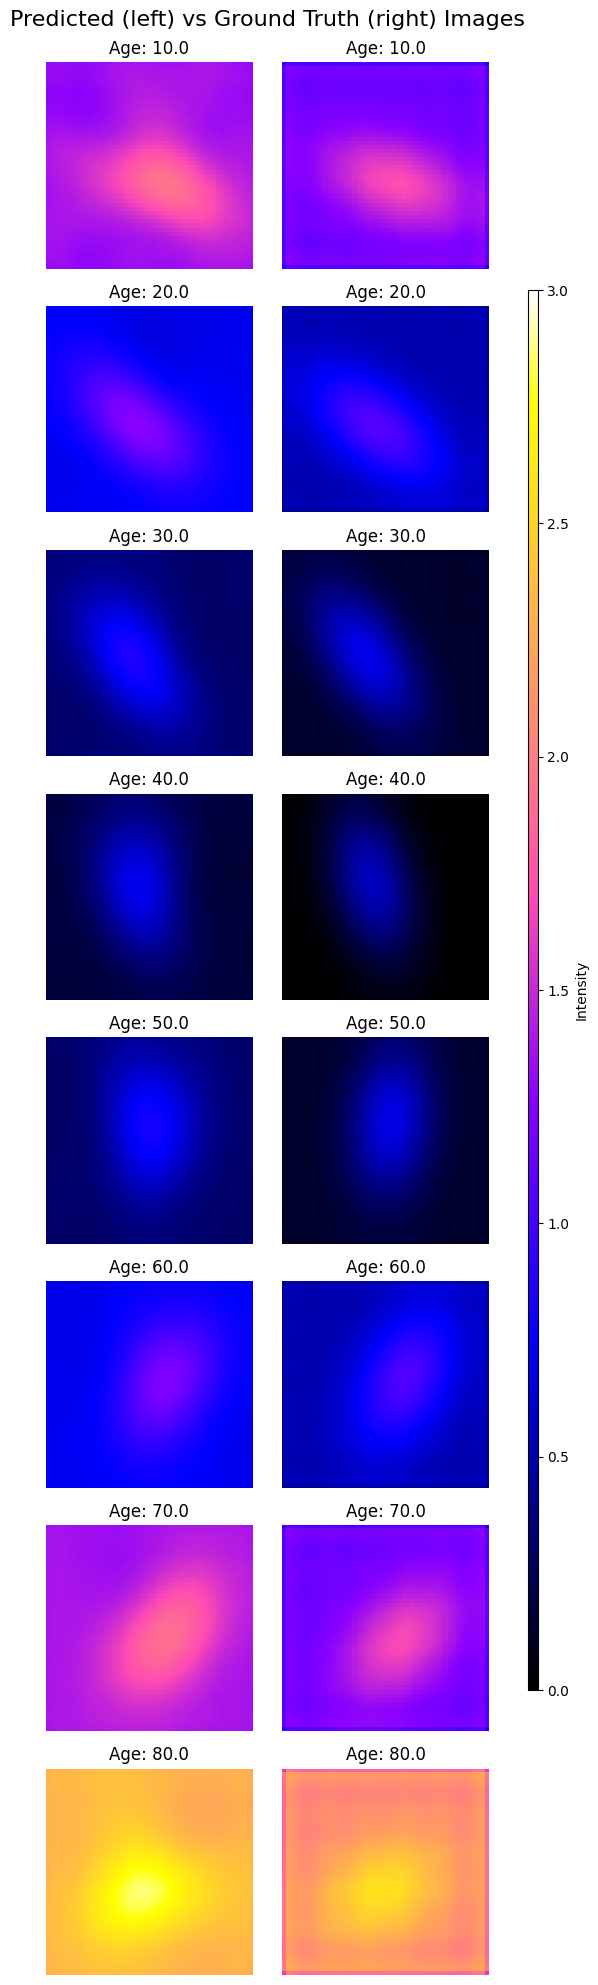

In [59]:
from sklearn.preprocessing import normalize
# queries encoding the high-dimensional data with a gaussian kernel smoother
gaussian_sigma = 0.05  # Adjust the sigma for the Gaussian kernel
pixel_queries = []
for i in range(2500):
    query = np.exp(
        -(
            (X - x[i % num_nodes])**2 +
            (Y - y[i // num_nodes])**2
        ) / (2 * gaussian_sigma**2)).flatten()
    pixel_queries.append(query / np.sum(query))  # Normalize the query to sum to 1
pixel_queries = np.array(pixel_queries)
pixel_queries_encoded = eigenmode_basis.encode(pixel_queries).T

# create dummy dataframe for prediction
candidate_dummy_df = pd.DataFrame({
    "age": candidate_ages,
})

# produce high-dimensional normative estimates
candidate_predictions = spectral_normative_model.predict(
    encoded_query=pixel_queries_encoded,
    test_covariates=candidate_dummy_df, predict_without=['site'],
).predictions

# Visualize the hypothetical images
fig, axes = plt.subplots(len(candidate_ages), 2, figsize=(5, 20))
for i, age in enumerate(candidate_ages):
    axes[i, 0].imshow(
        candidate_predictions["mu_estimate"][i].reshape(50, 50),
        cmap="gnuplot2", vmin=0, vmax=3.5)
    axes[i, 0].set_title(f"Age: {age:.1f}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(
        eigenmode_basis.decode(
            eigenmode_basis.encode(
                hypothetical_images[i].flatten() @ pixel_queries.T,
            ),
        ).reshape(50, 50),
        cmap="gnuplot2", vmin=0, vmax=3.5)
    axes[i, 1].set_title(f"Age: {age:.1f}")
    axes[i, 1].axis("off")

plt.suptitle(
    "Predicted (left) vs Ground Truth (right) Images",
    fontsize=16, y=0.99)

# Show the colorbar in a new axis on the right
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap="gnuplot2", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Intensity")
plt.tight_layout()
plt.show()


On the left, we have visualized the predictions of the spectral normative model (i.e., the normative median) at different ages, while on the right we have visualized the ground truth images at those ages (after encoding by the low-pass graph filter). This can show us how well the model captures the underlying normative process as captured by the low-pass graph filter (i.e., the eigenmode basis).

Notably, the model captures the changes in magnitude, direction and spatial extent of the images as characterized by our hypothetical process.

> Homework: you can try refitting a similar spectral normative model, but with inclusion of more modes (e.g., 200--500 modes instead of 100 modes), and see how this affects the model fit in the original data space, note how the number of modes affects the smoothness and spatial specificity of the fitted model.

## Quantifying goodness of fit

Having trained a normative model, we can now quantify the goodness of fit of the model to both the training data and the test data. To do this, we can use the [`SpectralNormativeModel.evaluate`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.evaluate) method, which computes various evaluation metrics to quantify the goodness of fit of the model to any given data.

You should note that the goodness of fit will also depend on the specific spatial query used to interrogate the model. For example, a simple model might give good fit metrics when interrogated with a spatial query that captures only the first few modes (e.g., very smooth spatial queries), but might give poor fit metrics when interrogated with a spatial query that captures more modes (e.g., more complex spatial queries). Therefore, it is important to consider the choice of spatial query when evaluating the goodness of fit of a spectral normative model.

Here, we will use the smooth gaussian kernel queries (as described in the previous section) to evaluate the goodness of fit of the model in the original data space. This will give us an estimate of how well the model captures the underlying normative process in the original data space, which is ultimately one of the hardest tasks in spectral normative modeling.

First, let's evaluate the model fit on the training data (we're showing the distribution of MSLL values across all pixels as an example):

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

2026-02-17 21:39:01 : [WARNING] - spectranorm.snm - Query moments not provided. Using test data moments as an approximation, which may lead to overestimating MSLL.


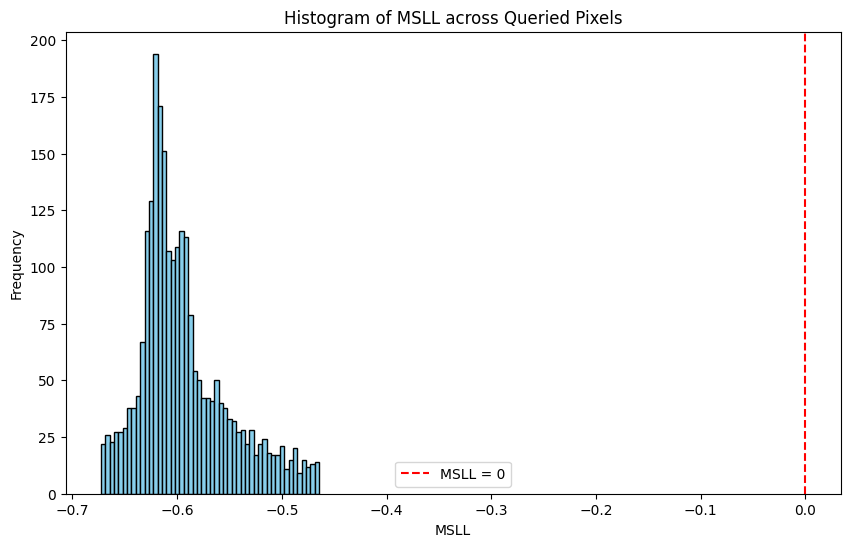

In [65]:
# training performance
training_performance = spectral_normative_model.evaluate(
    encoded_query=pixel_queries_encoded,
    spectral_coeff_test_data=spectral_coefficients_train,
    test_covariates=data,
)

# let's visualize MSLL across all pixels queried
plt.figure(figsize=(10, 6))
plt.hist(
    training_performance.evaluations["MSLL"],
    bins=50, color="skyblue", edgecolor="black")
plt.xlabel("MSLL")
plt.ylabel("Frequency")
plt.title("Histogram of MSLL across Queried Pixels")
plt.axvline(0, color="red", linestyle="--", label="MSLL = 0")
plt.legend()
plt.show()


Rest assured, we see that across all pixels, the MSLL values are negative, which indicates that the model is performing better than a trivial model with no normative assumption (i.e., a model that assumes that the data distribution is a gaussian distribution independent of the covariates). This is expected given that the data was generated from a process that follows a normative structure (i.e., data was generated from a distribution derived from the age covariate).

Notably, when generalizing to new unseen test data, it's recommended to provide the evaluate method with the `query_train_moments` argument, which contains the normative moments (mean and standard deviation) of the training data as estimated by the model for the provided spatial queries. This is mainly to get an accurate estimate of the MSLL metric, which is based on the comparison of the observed data distribution (a trivial gaussian with no normative assumption) to the normative distribution as estimated by the model. If this parameter is not provided, then the reported MSLL is incorrect, and can underestimate model performance (in the absence of training moments, these parameters are estimated from the provided test data).

The script below evaluates the model fit on the test data, and provides the training moments to get an accurate estimate of the MSLL metric:

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

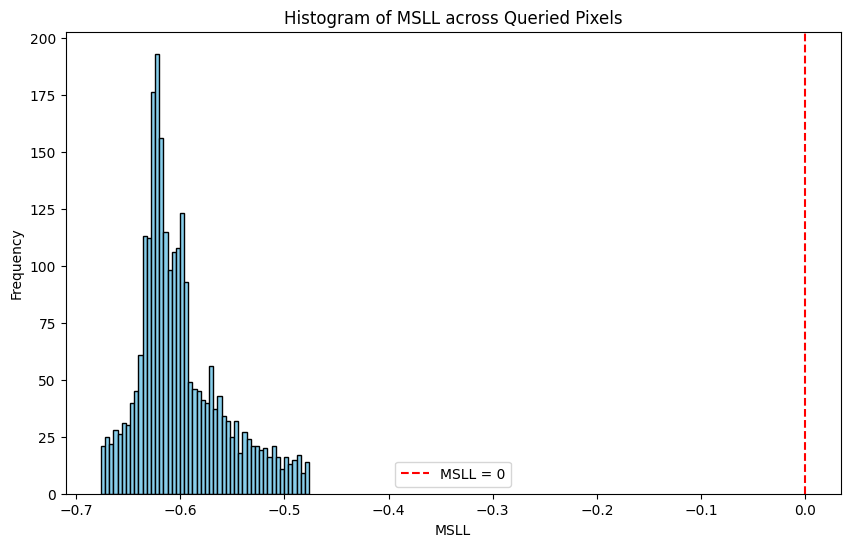

In [69]:
# training performance
test_performance = spectral_normative_model.evaluate(
    encoded_query=pixel_queries_encoded,
    spectral_coeff_test_data=spectral_coefficients_test,
    test_covariates=test_data,
    query_train_moments=np.array([
        np.mean(spectral_coefficients_train @ pixel_queries_encoded, axis=0),
        np.std(spectral_coefficients_train @ pixel_queries_encoded, axis=0, ddof=1),
    ]),
)

# let's visualize MSLL across all pixels queried
plt.figure(figsize=(10, 6))
plt.hist(
    test_performance.evaluations["MSLL"],
    bins=50, color="skyblue", edgecolor="black")
plt.xlabel("MSLL")
plt.ylabel("Frequency")
plt.title("Histogram of MSLL across Queried Pixels")
plt.axvline(0, color="red", linestyle="--", label="MSLL = 0")
plt.legend()
plt.show()


These test evaluations, indicate that the model is generalizing well to unseen data, as the MSLL values are negative across all pixels, which indicates that the model is performing better than a trivial model with no normative assumption on the test data as well.

Similar to the visualization with the training data, harmonization can be applied to the test data. The script below applies harmonization to the test data, and visualizes the observed data distribution along with the model fit for the spatial query corresponding to the first eigenmode coefficient:

In [70]:
# harmonizing the test data
harmonized_spectral_coefficients_test = spectral_normative_model.harmonize(
    encoded_query=encoded_queries[:n_queries],
    covariates_dataframe=test_data,
    spectral_coeff_data=spectral_coefficients_test[:,:n_queries],
    covariates_to_harmonize=["site"],
)

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

Computing direct eigenmode estimates:   0%|          | 0/100 [00:00<?, ?tasks/s]

Computing cross-mode dependence estimates:   0%|          | 0/49 [00:00<?, ?tasks/s]

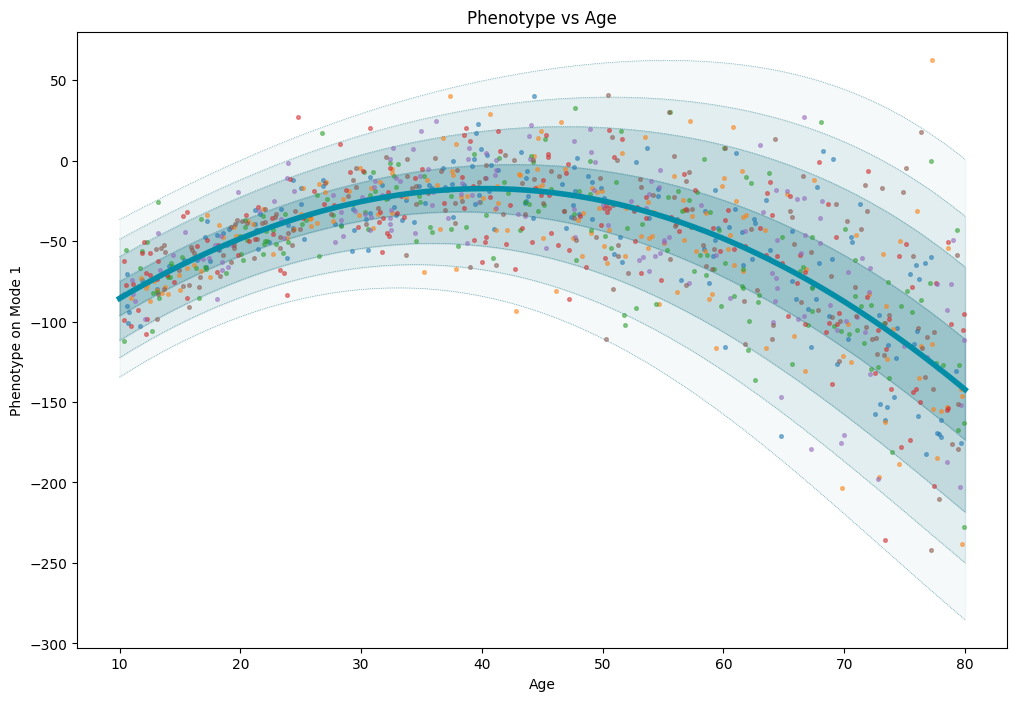

In [71]:
# Let's visualize the first mode's normative ranges as a function of age
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Predict moments (mean and std) of the normative distribution
moments = predicted_spectral_moments

# Let's compute charts along different quantiles
quantiles = [0.001, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

# Predict the phenotype values corresponding to different quantiles
phenotype_quantiles = {
    q: (moments["mu_estimate"][:,0] + stats.norm.ppf(q=q) * moments["std_estimate"][:,0])
    for q in quantiles
}

# Some colors for the plot
c1 = "#448e9c"  # brighter shade
c2 = "#038da6"  # darker shade

# Plotting shaded ranges for different quantiles
for q1, q2, alpha in [
    (0.001, 0.999, 0.05),
    (0.01, 0.99, 0.1),
    (0.05, 0.95, 0.2),
    (0.25, 0.75, 0.3)]:
    ax.fill_between(
        ages,
        phenotype_quantiles[q1],
        phenotype_quantiles[q2],
        alpha=alpha,
        color=c1,
    )

    # Now add boundary lines with different colors
    ax.plot(ages, phenotype_quantiles[q1], color=c1, lw=0.5, linestyle=":")
    ax.plot(ages, phenotype_quantiles[q2], color=c1, lw=0.5, linestyle=":")

# Finally, add the median line with a different color and higher line width
ax.plot(
    ages,
    phenotype_quantiles[0.5],
    c=c2,
    lw=4,
)

# In addition to the part above, the following add the encoded phenotype values
# as scatter points along the estimated normative range:
# the harmonized test data values are being used here
for site in sorted(test_data["site"].unique()):
    subset = test_data[test_data["site"] == site]
    plt.scatter(
        subset["age"], harmonized_spectral_coefficients_test[subset.index][:,0],
        alpha=0.5, label=f"{site}", s=7)

plt.xlabel("Age")
plt.ylabel("Phenotype on Mode 1")
plt.title("Phenotype vs Age");



## Saving the model

To finish this tutorial on spectral normative modeling, it's worth mentioning that the fitted spectral normative model can be saved to disk using the [`SpectralNormativeModel.save_model`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.save_model) method, which saves the model parameters and specifications to a directory created at the specific path. This allows you to load the model later for inference or further analysis without needing to refit the model from scratch.

Notably, this saved instance will contain both the eigenmode basis and the normative model specifications. As such, when sharing pretrained spectral normative models, all you need to provide is the directory path to wich this file was saved. Note that we recommend saving the model in a new/empty directory. The save method may create multiple files in the provided directory. When sharing pretrained models, you can simply share the whole directory, or a compressed version of the directory (e.g., a zip file) to share the pretrained model.

In [72]:
from pathlib import Path

model_save_path = Path("./tmp_directory")
# ensure the directory exists
model_save_path.mkdir(exist_ok=True)
# ensure the directory is empty (no files or directories inside)
if any(model_save_path.iterdir()):
    msg = (
        f"The directory {model_save_path} is not empty. "
        f"Please provide an empty directory for saving the model."
    )
    raise ValueError(msg)

spectral_normative_model.save_model(model_save_path)


## Loading the model

Finally, now that the model is saved, you can load it later using the [`SpectralNormativeModel.load_model`](/spectranorm/api/snm/#spectranorm.snm.SpectralNormativeModel.load_model) method, which loads the model parameters and specifications from the provided directory path. This allows you to use a shared pretrained model for inference or further analysis.

In [73]:
loaded_spectral_normative_model = snm.SpectralNormativeModel.load_model(model_save_path)

## Concluding remarks

This tutorial provided an introductory walkthrough of how to perform spectral normative modeling using the SpectraNorm package. We covered the process of defining a spectral normative model, fitting it to data, visualizing the model fit in both the spectral and original data spaces, evaluating the goodness of fit, and saving/loading the model for future use. This tutorial serves as a starting point for understanding the capabilities of spectral normative modeling, and how it can be applied to data defined on graphs.

In future tutorials, we will explore how spectral normative models can be applied to brain imaging data specifically. This will provide us with the opportunity to cover specific neuroimaging-related utilities of the package, and to demonstrate how previously provided pretrained spectral normative models can be used for inference on new data.